In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from typing import Iterable, List
import numpy as np
import math
from SpatialPooler import SpatialPooler
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from util.metrics import get_mean_similiraty, similiraty_to_percent, get_similiraty
from util.plots import plot_images, plot_image
from util.data import sample_class, encode_img

<IPython.core.display.Javascript object>

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape

(60000, 28, 28)

<IPython.core.display.Javascript object>

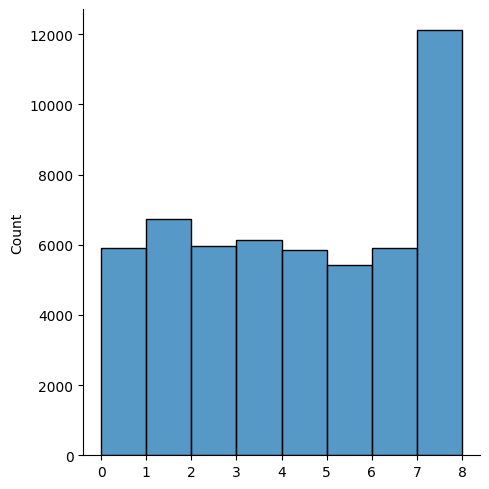

<IPython.core.display.Javascript object>

In [4]:
sns.displot(y_train, bins=(range(0, 9)))

In [5]:
inp_shape = x_train[0].shape
inp_shape

(28, 28)

<IPython.core.display.Javascript object>

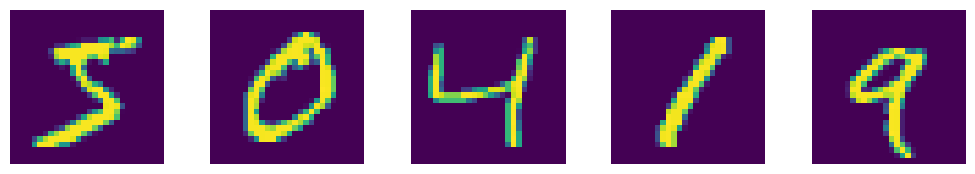

<IPython.core.display.Javascript object>

In [6]:
plot_images(x_train[:5])

In [7]:
COLUMN_SPARSITY = 0.2
COLUMN_DIM = (32, 32)

<IPython.core.display.Javascript object>

In [26]:
sp = SpatialPooler(
    input_dimension=inp_shape,
    column_dimension=COLUMN_DIM,
    connection_sparsity=0.8,
    permanence_threshold=0.5,
    stimulus_threshold=15.0,
    permanence_increment=0.1,
    permanence_decrement=0.02,
    column_sparsity=COLUMN_SPARSITY,
)

<IPython.core.display.Javascript object>

In [27]:
samples = sample_class(x_train, y_train, 5, 5000, False)
samples = encode_img(samples)

<IPython.core.display.Javascript object>

In [28]:
for sample in tqdm(samples):
    sp.compute(sample, learn=True)
sp.save_state("sp_state")

  0%|          | 0/5000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [29]:
def get_sdrs(samples: np.ndarray) -> np.ndarray:
    sdrs = np.zeros((samples.shape[0], 1024))
    for idx, sample in enumerate(samples):
        sample = sample.astype("int32")
        sample[sample > 0] = 1
        active_columns = sp.compute(sample.reshape(28, 28), learn=False)
        sdr = sp.top_columns_to_sdr(active_columns)
        sdrs[idx] = sdr

    return sdrs

<IPython.core.display.Javascript object>

In [30]:
sdrs = get_sdrs(samples[:5])

<IPython.core.display.Javascript object>

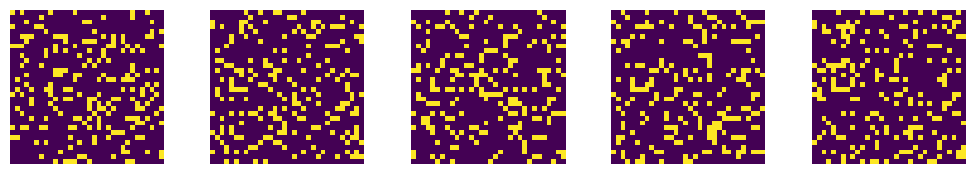

<IPython.core.display.Javascript object>

In [23]:
plot_images(sdrs.reshape((5, 32, 32)))

In [14]:
active_columns = sp.compute(samples[1].reshape(28, 28), learn=False)
sdr = sp.top_columns_to_sdr(active_columns)

<IPython.core.display.Javascript object>

TypeError: 'AxesSubplot' object is not subscriptable

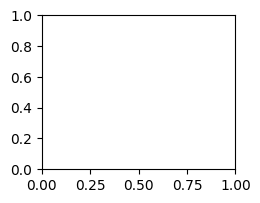

<IPython.core.display.Javascript object>

In [15]:
plot_images(samples[1].reshape((1, 28, 28)))

In [ ]:
plot_image(samples[1].reshape((28, 28)))

In [31]:
fives = np.argwhere(y_train == 5)[:25]
fives = x_train[fives]
fives = get_sdrs(fives)
ref_fives = fives[:5]
test_fives = fives[5:]

sixes = np.argwhere(y_train == 6)[:25]
sixes = x_train[sixes]
sixes = get_sdrs(sixes)
ref_sixes = sixes[:5]
test_sixes = sixes[5:]

<IPython.core.display.Javascript object>

In [32]:
sim = get_similiraty(ref_fives, test_fives[0])
mean_sim = get_mean_similiraty(ref_fives, test_fives[0])
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

similiraty scores: [66. 63. 68. 76. 56.]
mean similiraty: 65.8
similiraty in %: 32.13%


<IPython.core.display.Javascript object>

In [ ]:
sim = get_similiraty(ref_sixes, test_fives[0])
mean_sim = get_mean_similiraty(ref_sixes, test_fives[0])
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

In [ ]:
sim = get_similiraty(ref_sixes, test_sixes[0])
mean_sim = get_mean_similiraty(ref_sixes, test_sixes[0])
sim_percent = similiraty_to_percent(mean_sim, COLUMN_SPARSITY, np.prod(COLUMN_DIM))

print(f"similiraty scores: {sim}")
print(f"mean similiraty: {mean_sim}")
print(f"similiraty in %: {sim_percent:.2%}")

In [ ]:
plot_images(test_sixes.reshape((test_sixes.shape[0], 32, 32))[:5])

In [ ]:
plot_images(test_fives.reshape((test_fives.shape[0], 32, 32))[:5])

In [ ]:
len(test_fives[0][test_fives[0] > 0])

In [ ]:
len(test_sixes[0][test_sixes[0] > 0])

In [ ]:
0.2 * 32 * 32